<a href="https://colab.research.google.com/github/angelrecalde2024/Power-System-Planning-and-Transmission-Design-2026/blob/main/ShortTermLFwithANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

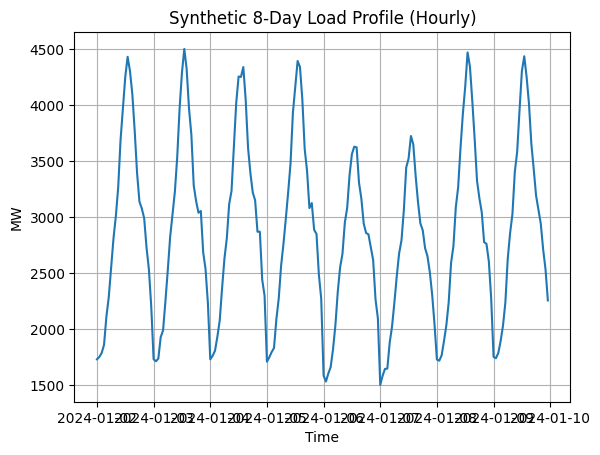

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


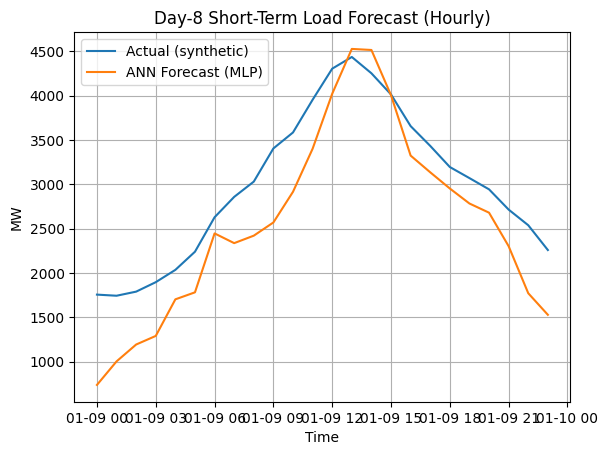

Day-8 forecast error metrics:
  MAE_MW: 462.6439
  RMSE_MW: 525.1762
  MAPE_pct: 18.4027


,y_true,y_pred
2024-01-09 00:00:00,1755.252220,736.437808
2024-01-09 01:00:00,1742.631900,1001.935206
2024-01-09 02:00:00,1788.956824,1192.294176
2024-01-09 03:00:00,1895.674589,1289.163029
2024-01-09 04:00:00,2034.448581,1701.995878
2024-01-09 05:00:00,2239.243667,1781.030617
2024-01-09 06:00:00,2627.939045,2445.761011
2024-01-09 07:00:00,2857.776765,2336.034261
2024-01-09 08:00:00,3030.111901,2420.366841
2024-01-09 09:00:00,3404.390352,2569.248871


In [15]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error


# =========================
# 1) Configuration
# =========================

@dataclass(frozen=True)
class STLFConfig:
    """
    Purpose
    -------
    Holds tunable parameters for the short-term synthetic dataset and MLP forecast experiment.

    Inputs (fields)
    --------------
    start : str
        Start timestamp for the 8-day series.
    days : int
        Number of days to generate (default 8).
    seed : int
        Random seed for reproducibility.
    national_peak_mw : float
        Approximate national peak scaling (MW) over the short horizon.
    population_growth_annual : float
        Included for consistency with the long-term model; effect is tiny over 8 days.
    share_industrial : float
        Fraction of total load attributed to industry (Ecuador spec: 15%).
    share_public : float
        Fraction of total load attributed to public/institutional (Ecuador spec: 20%).
    share_commercial : float
        Fraction of total load attributed to commercial (Ecuador spec: 35%).
    share_residential : float
        Remaining fraction attributed to residential.
    coast_cooling_threshold_c : float
        Cooling activates above this temperature for the coast.
    coast_cooling_sensitivity : float
        Strength of cooling load vs degrees above threshold.
    highlands_heating_threshold_c : float
        Heating activates below this temperature for the highlands.
    highlands_heating_sensitivity : float
        Strength of heating vs degrees below threshold.
    highlands_heater_penetration : float
        Fraction of consumers with heaters (small share).

    Outputs
    -------
    None (this is a config container).
    """
    start: str = "2024-01-01 00:00:00"
    days: int = 9 # Changed from 8 to 9 to account for lag feature dropna()
    seed: int = 42

    national_peak_mw: float = 5200.0
    population_growth_annual: float = 0.035

    share_industrial: float = 0.15
    share_public: float = 0.20
    share_commercial: float = 0.35
    share_residential: float = 0.30

    coast_cooling_threshold_c: float = 26.0
    coast_cooling_sensitivity: float = 0.020

    highlands_heating_threshold_c: float = 14.0
    highlands_heating_sensitivity: float = 0.010
    highlands_heater_penetration: float = 0.15


# =========================
# 2) Synthetic data generator (8-day)
# =========================

def make_hourly_index(cfg: STLFConfig) -> pd.DatetimeIndex:
    """
    Purpose
    -------
    Create an hourly timestamp index for cfg.days.

    Inputs
    ------
    cfg : STLFConfig
        Uses cfg.start and cfg.days.

    Outputs
    -------
    pd.DatetimeIndex
        Hourly timestamps covering [start, start + days) with 24*days points.
    """
    start = pd.Timestamp(cfg.start)
    end = start + pd.Timedelta(days=cfg.days)
    return pd.date_range(start=start, end=end, freq="h", inclusive="left")


def seasonal_cos(doy: np.ndarray, peak_doy: int, period: int = 365) -> np.ndarray:
    """
    Purpose
    -------
    Produce a smooth seasonal cosine in [-1, 1], used for temperature seasonality.

    Inputs
    ------
    doy : np.ndarray
        Day-of-year values.
    peak_doy : int
        Day-of-year where cosine is maximal (hottest/coldest reference).
    period : int
        Seasonal period, default 365.

    Outputs
    -------
    np.ndarray
        Cosine seasonality values in [-1, 1].
    """
    return np.cos(2.0 * np.pi * (doy - peak_doy) / period)


def synthesize_temperature_8d(index: pd.DatetimeIndex, cfg: STLFConfig) -> pd.DataFrame:
    """
    Purpose
    -------
    Generate hourly synthetic temperatures for Coast and Highlands, plus a national proxy.
    Mirrors the long-term approach (diurnal + seasonal + noise), but over 8 days.

    Inputs
    ------
    index : pd.DatetimeIndex
        Hourly timestamps for the 8-day horizon.
    cfg : STLFConfig
        Uses cfg.seed for reproducibility.

    Outputs
    -------
    pd.DataFrame
        Indexed by timestamp with columns:
          - temp_coast_c
          - temp_highlands_c
          - temp_national_c
    """
    rng = np.random.default_rng(cfg.seed)

    doy = index.dayofyear.to_numpy()
    hour = index.hour.to_numpy()

    # Diurnal component: warmest in early afternoon
    diurnal = 1.8 * np.sin(2.0 * np.pi * (hour - 14) / 24.0)

    # Coast: hottest season around Feb (peak_doy ~ 45)
    coast_season = 3.2 * seasonal_cos(doy, peak_doy=45)
    temp_coast = 27.5 + coast_season + diurnal + rng.normal(0.0, 0.8, size=len(index))

    # Highlands: coldest season around Aug (peak_doy ~ 225 but negative sign)
    high_season = -2.6 * seasonal_cos(doy, peak_doy=225)
    temp_high = 15.5 + high_season + 0.7 * diurnal + rng.normal(0.0, 0.7, size=len(index))

    # National proxy
    temp_nat = 0.58 * temp_coast + 0.42 * temp_high

    return pd.DataFrame(
        {
            "temp_coast_c": temp_coast,
            "temp_highlands_c": temp_high,
            "temp_national_c": temp_nat,
        },
        index=index,
    )


def synthesize_macro_8d(index: pd.DatetimeIndex, cfg: STLFConfig) -> pd.DataFrame:
    """
    Purpose
    -------
    Generate simplified macro/demographic drivers over 8 days.
    Over such a short horizon, these mostly add small correlated variability.

    Inputs
    ------
    index : pd.DatetimeIndex
        Hourly timestamps.
    cfg : STLFConfig
        Uses cfg.seed and cfg.population_growth_annual.

    Outputs
    -------
    pd.DataFrame
        Indexed by timestamp with columns:
          - oil_price_usd (slow random walk)
          - remittances_index (mild noise)
          - population_index (almost constant over 8 days)
    """
    rng = np.random.default_rng(cfg.seed + 1)

    n = len(index)
    hours_per_year = 365.0 * 24.0
    t_years = np.arange(n) / hours_per_year

    # Oil price: tiny random walk around a baseline
    oil = np.empty(n)
    oil[0] = 65.0
    for i in range(1, n):
        pull = 0.01 * (65.0 - oil[i - 1])
        shock = rng.normal(0.0, 1.0) * 0.08
        oil[i] = max(20.0, oil[i - 1] + pull + shock)

    # Remittances index: mild noise
    rem = 100.0 + rng.normal(0.0, 1.5, size=n)

    # Population index: deterministic growth from 1.0 (almost flat in 8 days)
    pop = np.exp(np.log(1.0 + cfg.population_growth_annual) * t_years)

    return pd.DataFrame(
        {"oil_price_usd": oil, "remittances_index": rem, "population_index": pop},
        index=index,
    )


def calendar_features(index: pd.DatetimeIndex) -> pd.DataFrame:
    """
    Purpose
    -------
    Produce standard STLF calendar predictors:
      - hour-of-day one-hot (h_0..h_23)
      - day-of-week one-hot (dow_0..dow_6)
      - weekend flag

    Inputs
    ------
    index : pd.DatetimeIndex
        Hourly timestamps.

    Outputs
    -------
    pd.DataFrame
        Indexed by timestamp with numeric columns described above.
    """
    df = pd.DataFrame(index=index)
    df["hour"] = index.hour
    df["dow"] = index.dayofweek
    df["is_weekend"] = (df["dow"] >= 5).astype(float)

    hour_oh = pd.get_dummies(df["hour"], prefix="h", dtype=float)
    dow_oh = pd.get_dummies(df["dow"], prefix="dow", dtype=float)

    return pd.concat([hour_oh, dow_oh, df[["is_weekend"]]], axis=1)


def synthesize_sector_loads_8d(
    index: pd.DatetimeIndex,
    temps: pd.DataFrame,
    macro: pd.DataFrame,
    cfg: STLFConfig,
) -> pd.DataFrame:
    """
    Purpose
    -------
    Generate sectoral loads and total load using the same logic style as the long-term case:
      - residential: morning/evening peaks + coastal cooling + limited highlands heating
      - commercial/public: daytime peak + weekday effect
      - industrial: flatter + weekday effect
    Sector shares follow Ecuador specs.

    Inputs
    ------
    index : pd.DatetimeIndex
        Hourly timestamps.
    temps : pd.DataFrame
        Must contain temp_coast_c and temp_highlands_c.
    macro : pd.DataFrame
        Must contain population_index, oil_price_usd, remittances_index.
    cfg : STLFConfig
        Uses shares, temperature sensitivities, and scaling parameters.

    Outputs
    -------
    pd.DataFrame
        Indexed by timestamp with columns:
          load_res_mw, load_com_mw, load_ind_mw, load_pub_mw, load_total_mw
    """
    rng = np.random.default_rng(cfg.seed + 2)
    n = len(index)

    hour = index.hour.to_numpy()
    dow = index.dayofweek.to_numpy()
    is_weekend = (dow >= 5).astype(float)
    weekday_factor = 1.0 - 0.18 * is_weekend

    # Shape templates (normalized)
    res_shape = (
        0.35
        + 0.35 * np.exp(-0.5 * ((hour - 7) / 2.2) ** 2)
        + 0.45 * np.exp(-0.5 * ((hour - 20) / 2.6) ** 2)
    )
    res_shape /= res_shape.max()

    day_peak = 0.20 + 0.90 * np.exp(-0.5 * ((hour - 13) / 3.0) ** 2)
    day_peak /= day_peak.max()

    ind_shape = 0.65 + 0.35 * np.exp(-0.5 * ((hour - 14) / 4.5) ** 2)
    ind_shape /= ind_shape.max()

    # Temperature effects
    coast_temp = temps["temp_coast_c"].to_numpy()
    high_temp = temps["temp_highlands_c"].to_numpy()

    cooling = np.maximum(0.0, coast_temp - cfg.coast_cooling_threshold_c)
    cooling_mult = 1.0 + cfg.coast_cooling_sensitivity * cooling

    heating = np.maximum(0.0, cfg.highlands_heating_threshold_c - high_temp)
    heating_mult = 1.0 + cfg.highlands_heating_sensitivity * heating * cfg.highlands_heater_penetration

    # Macro effects (very small over 8 days, but keeps same style)
    pop = macro["population_index"].to_numpy()
    oil = macro["oil_price_usd"].to_numpy()
    rem = macro["remittances_index"].to_numpy()

    oil_norm = (oil - oil.mean()) / (oil.std() + 1e-9)
    rem_norm = (rem - rem.mean()) / (rem.std() + 1e-9)
    macro_mult = pop * (1.0 + 0.01 * rem_norm + 0.008 * oil_norm)

    # Scale total peak
    peak = cfg.national_peak_mw * macro_mult

    # Normalize shares just in case
    s = cfg.share_residential + cfg.share_commercial + cfg.share_industrial + cfg.share_public
    res_share = cfg.share_residential / s
    com_share = cfg.share_commercial / s
    ind_share = cfg.share_industrial / s
    pub_share = cfg.share_public / s

    res_peak = peak * res_share
    com_peak = peak * com_share
    ind_peak = peak * ind_share
    pub_peak = peak * pub_share

    # Sector loads (add small noise)
    res = res_peak * res_shape * (0.65 + 0.35 * cooling_mult) * (0.92 + 0.08 * heating_mult) * (1.0 + 0.03 * rng.normal(size=n))
    com = com_peak * day_peak * weekday_factor * (1.0 + 0.02 * rng.normal(size=n))
    ind = ind_peak * ind_shape * weekday_factor * (1.0 + 0.015 * rng.normal(size=n))
    pub = pub_peak * day_peak * weekday_factor * (0.97 + 0.03 * heating_mult) * (1.0 + 0.02 * rng.normal(size=n))

    res = np.clip(res, 0.0, None)
    com = np.clip(com, 0.0, None)
    ind = np.clip(ind, 0.0, None)
    pub = np.clip(pub, 0.0, None)

    total = res + com + ind + pub

    return pd.DataFrame(
        {
            "load_res_mw": res,
            "load_com_mw": com,
            "load_ind_mw": ind,
            "load_pub_mw": pub,
            "load_total_mw": total,
        },
        index=index,
    )


def build_synthetic_8day_dataset(cfg: STLFConfig) -> pd.DataFrame:
    """
    Purpose
    -------
    Build the full 8-day dataset: loads + predictors (temps, macro, calendar) + lag features.

    Inputs
    ------
    cfg : STLFConfig
        Controls generation parameters.

    Outputs
    -------
    pd.DataFrame
        Indexed by timestamp with:
          - load_* columns (res/com/ind/pub/total)
          - temperature columns
          - macro columns
          - calendar feature columns
          - lag features: lag_1h, lag_24h for total load
    """
    index = make_hourly_index(cfg)
    temps = synthesize_temperature_8d(index, cfg)
    macro = synthesize_macro_8d(index, cfg)
    cal = calendar_features(index)
    loads = synthesize_sector_loads_8d(index, temps, macro, cfg)

    df = pd.concat([loads, temps, macro, cal], axis=1)

    # Lags for STLF
    df["lag_1h"] = df["load_total_mw"].shift(1)
    df["lag_24h"] = df["load_total_mw"].shift(24)

    return df.dropna()


# =========================
# 3) Feature builder for ANN
# =========================

def build_supervised_mlp_data(
    df: pd.DataFrame,
    target_col: str,
    feature_cols: List[str],
    train_days: int = 7,
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Purpose
    -------
    Split the 8-day dataset into supervised train (days 1..train_days) and test (day 8),
    returning (X_train, y_train, X_test, y_test).

    Inputs
    ------
    df : pd.DataFrame
        8-day dataframe indexed by timestamp.
    target_col : str
        Name of target column (e.g., "load_total_mw").
    feature_cols : List[str]
        List of predictor columns to use in the ANN.
    train_days : int
        Number of days used for training (default 7).

    Outputs
    -------
    pd.DataFrame
        Feature matrix for training.
    pd.Series
        Target vector for training.
    pd.DataFrame
        Feature matrix for day-8 forecasting/evaluation.
    pd.Series
        Target vector (actual) for day-8 evaluation.
    """
    start = df.index.min()
    train_end = start + pd.Timedelta(days=train_days)
    test_end = start + pd.Timedelta(days=train_days + 1)

    train = df.loc[(df.index >= start) & (df.index < train_end)].copy()
    test = df.loc[(df.index >= train_end) & (df.index < test_end)].copy()

    if len(train) == 0 or len(test) == 0:
        raise ValueError("Train/test split failed. Check timestamps and train_days.")

    X_train = train[feature_cols].astype(float)
    y_train = train[target_col].astype(float)

    X_test = test[feature_cols].astype(float)
    y_test = test[target_col].astype(float)

    return X_train, y_train, X_test, y_test


# =========================
# 4) ANN (MLP) training + day-8 rolling forecast
# =========================

def train_mlp_and_forecast_day8(
    df: pd.DataFrame,
    *,
    target_col: str,
    feature_cols: List[str],
    forecast_start: pd.Timestamp,
    hidden_layer_sizes: Tuple[int, ...] = (32, 16),
    activation: str = "relu",
    solver: str = "adam",
    alpha: float = 1e-4,
    learning_rate_init: float = 1e-3,
    max_iter: int = 500,
    #early_stopping: bool = True,
    #validation_fraction: float = 0.2,
    #n_iter_no_change: int = 20,
    random_state: int = 1,
) -> Tuple[Pipeline, pd.DataFrame]:
    """
    Purpose
    -------
    Train an ANN (MLPRegressor) on days 1–7 and forecast day 8 hour-by-hour.

    Important conceptual notes (detailed)
    ------------------------------------
    The ANN used here is an MLP (Multi-Layer Perceptron), a feedforward neural network.

    Components and why they exist:
    1) StandardScaler (input normalization)
       - Purpose: ANN training is sensitive to input scales.
       - We standardize each feature to mean=0, std=1 using ONLY training data.
       - This improves numerical stability and convergence for gradient-based learning.

    2) MLPRegressor (the ANN model)
       - hidden_layer_sizes:
           Tuple like (32, 16) means two hidden layers:
             Layer1: 32 neurons
             Layer2: 16 neurons
         More neurons => more flexibility but higher overfitting risk (especially with small datasets).
       - activation:
           'relu' is common for modern MLPs; introduces nonlinearity.
           Nonlinearity is key: it allows modeling temperature thresholds and interactions.
       - solver:
           'adam' is a robust stochastic gradient descent variant.
       - alpha:
           L2 regularization strength; helps reduce overfitting.
       - learning_rate_init:
           Initial step size for optimizer.
       - max_iter:
           Maximum training iterations. If the network doesn't converge, increase this.
       - random_state:
           Ensures reproducible weight initialization.

    Training objective:
      Minimize mean squared error (MSE) on training samples via backpropagation + gradient descent.

    Forecast approach:
    - We use a rolling 1-step-ahead method across the 24 hours of day 8.
    - At hour t in day 8, features include lag_1h and lag_24h:
        * lag_24h is known from the previous day (day 7 actual).
        * lag_1h for the first hour is last hour of day 7 actual.
        * for subsequent hours, lag_1h becomes the model’s own previous prediction.
      This matches realistic STLF where you forecast sequentially.

    Inputs
    ------
    df : pd.DataFrame
        Must include target_col and feature_cols, and contain 8 days of hourly rows.
    target_col : str
        Target to forecast (e.g., "load_total_mw").
    feature_cols : List[str]
        Predictors used by the MLP (must include lag_1h and lag_24h if you want autoregression).
    forecast_start : pd.Timestamp
        Timestamp of day 8 start (i.e., start + 7 days).
    hidden_layer_sizes, activation, solver, alpha, learning_rate_init, max_iter, random_state
        MLP hyperparameters (see explanation above).

    Outputs
    -------
    model : sklearn Pipeline
        Pipeline(StandardScaler -> MLPRegressor) fitted on training data.
    forecast_df : pd.DataFrame
        Indexed by day-8 timestamps with columns:
          y_true, y_pred
    """
    # Split into train (before forecast_start) and day-8 test window
    train = df.loc[df.index < forecast_start].copy()
    test = df.loc[(df.index >= forecast_start) & (df.index < forecast_start + pd.Timedelta(days=1))].copy()
    if len(test) != 24:
        raise ValueError("Expected exactly 24 hours for day-8 forecast window.")

    # Prepare train arrays
    X_train = train[feature_cols].astype(float)
    y_train = train[target_col].astype(float)

    # Build the ANN pipeline: scaling + MLP
    model = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("mlp", MLPRegressor(
                hidden_layer_sizes=hidden_layer_sizes,
                activation=activation,
                solver=solver,
                alpha=alpha,
                learning_rate_init=learning_rate_init,
                max_iter=max_iter,
                #early_stopping=early_stopping,
                #validation_fraction=validation_fraction,
                #n_iter_no_change=n_iter_no_change,
                random_state=random_state,
            )),
        ]
    )
    model.fit(X_train, y_train)

    # Rolling forecast for day 8
    preds = []
    prev_pred = None

    for ts in test.index:
        row = test.loc[ts, feature_cols].astype(float).copy()

        # Replace lag_1h with last prediction after the first step
        if "lag_1h" in feature_cols and prev_pred is not None:
            row.loc["lag_1h"] = prev_pred

        y_hat = float(model.predict(pd.DataFrame([row], columns=feature_cols))[0])
        preds.append(y_hat)
        prev_pred = y_hat

    forecast_df = pd.DataFrame(
        {"y_true": test[target_col].astype(float).values, "y_pred": np.array(preds, dtype=float)},
        index=test.index,
    )
    return model, forecast_df


# =========================
# 5) Metrics + plots
# =========================

def compute_error_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """
    Purpose
    -------
    Compute standard STLF error metrics.

    Inputs
    ------
    y_true : np.ndarray
        Ground-truth load values.
    y_pred : np.ndarray
        Forecast load values.

    Outputs
    -------
    Dict[str, float]
        MAE (MW), RMSE (MW), MAPE (%).
    """
    mae = float(mean_absolute_error(y_true, y_pred))
    rmse = float(math.sqrt(mean_squared_error(y_true, y_pred)))

    denom = np.maximum(1e-6, np.abs(y_true))
    mape = float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

    return {"MAE_MW": mae, "RMSE_MW": rmse, "MAPE_pct": mape}


def plot_8day_profile(df: pd.DataFrame, target_col: str) -> None:
    """
    Purpose
    -------
    Plot the full 8-day hourly load profile to visualize training + forecast periods.

    Inputs
    ------
    df : pd.DataFrame
        Dataset indexed by timestamp.
    target_col : str
        Column to plot (e.g., load_total_mw).

    Outputs
    -------
    None (displays a plot).
    """
    plt.figure()
    plt.plot(df.index, df[target_col].values)
    plt.title("Synthetic 8-Day Load Profile (Hourly)")
    plt.xlabel("Time")
    plt.ylabel("MW")
    plt.grid(True)
    plt.show()


def plot_day8_forecast(forecast_df: pd.DataFrame) -> None:
    """
    Purpose
    -------
    Plot actual vs forecast for the 8th day (24 hours).

    Inputs
    ------
    forecast_df : pd.DataFrame
        Indexed by timestamp with columns y_true, y_pred.

    Outputs
    -------
    None (displays a plot).
    """
    plt.figure()
    plt.plot(forecast_df.index, forecast_df["y_true"], label="Actual (synthetic)")
    plt.plot(forecast_df.index, forecast_df["y_pred"], label="ANN Forecast (MLP)")
    plt.title("Day-8 Short-Term Load Forecast (Hourly)")
    plt.xlabel("Time")
    plt.ylabel("MW")
    plt.grid(True)
    plt.legend()
    plt.show()


# =========================
# 6) Run the STLF experiment
# =========================

TRAIN_DAYS = 7
FORECAST_DAYS = 1
MAX_LAG_HOURS = 24  # because lag_24h

cfg = STLFConfig(
    start="2024-01-01 00:00:00",
    days=TRAIN_DAYS + FORECAST_DAYS + (MAX_LAG_HOURS // 24),
    seed=42,
    national_peak_mw=5200.0,
    population_growth_annual=0.035,
)

df8 = build_synthetic_8day_dataset(cfg)

# Choose ANN features (students can edit these)
# Minimal strong baseline: temperature + calendar + lags
hour_cols = [c for c in df8.columns if c.startswith("h_")]
dow_cols = [c for c in df8.columns if c.startswith("dow_")]

feature_cols = (
    ["temp_national_c", "is_weekend", "lag_1h", "lag_24h"]
    + hour_cols
    + dow_cols
)

target_col = "load_total_mw"

# Plot the full 8-day profile
plot_8day_profile(df8, target_col=target_col)

# Day-8 start time (after 7 days)
forecast_start = df8.index.min() + pd.Timedelta(days=TRAIN_DAYS)

# Train MLP and forecast day 8
model, fc8 = train_mlp_and_forecast_day8(
    df8,
    target_col=target_col,
    feature_cols=feature_cols,
    forecast_start=forecast_start,
    hidden_layer_sizes=(32, 16),  # smaller for 168 samples, previous:(32,16)
    activation="relu",
    solver="adam",
    alpha=1e-4,                   # stronger L2, previous: 1e-4
    learning_rate_init=1e-3,      # slightly smaller LR, previous:1e-3,
    max_iter=1000,                # previous: 1000
    #early_stopping=True,
    #validation_fraction=0.2,
    #n_iter_no_change=20,
    random_state=1,
)

# Plot day-8 results
plot_day8_forecast(fc8)

# Compute metrics
metrics = compute_error_metrics(fc8["y_true"].values, fc8["y_pred"].values)
print("Day-8 forecast error metrics:")
for k, v in metrics.items():
    print(f"  {k}: {v:.4f}")

# Optional: show forecast table
display(fc8)
